**Importando as bibliotecas necessárias**

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut


**LENDO ARQUIVO CSV**

In [22]:
df = pd.read_csv('[BD] Decisão Imóveis.csv')

**Bairro com maior número de imóveis**

In [23]:
bairro_maior_num_imoveis = df['Bairro'].value_counts().idxmax()
print(f'O bairro com maior número de imóveis é: {bairro_maior_num_imoveis}')

O bairro com maior número de imóveis é: Funcionários 


**Número de imóveis por bairro (Plotando o gráfico)**

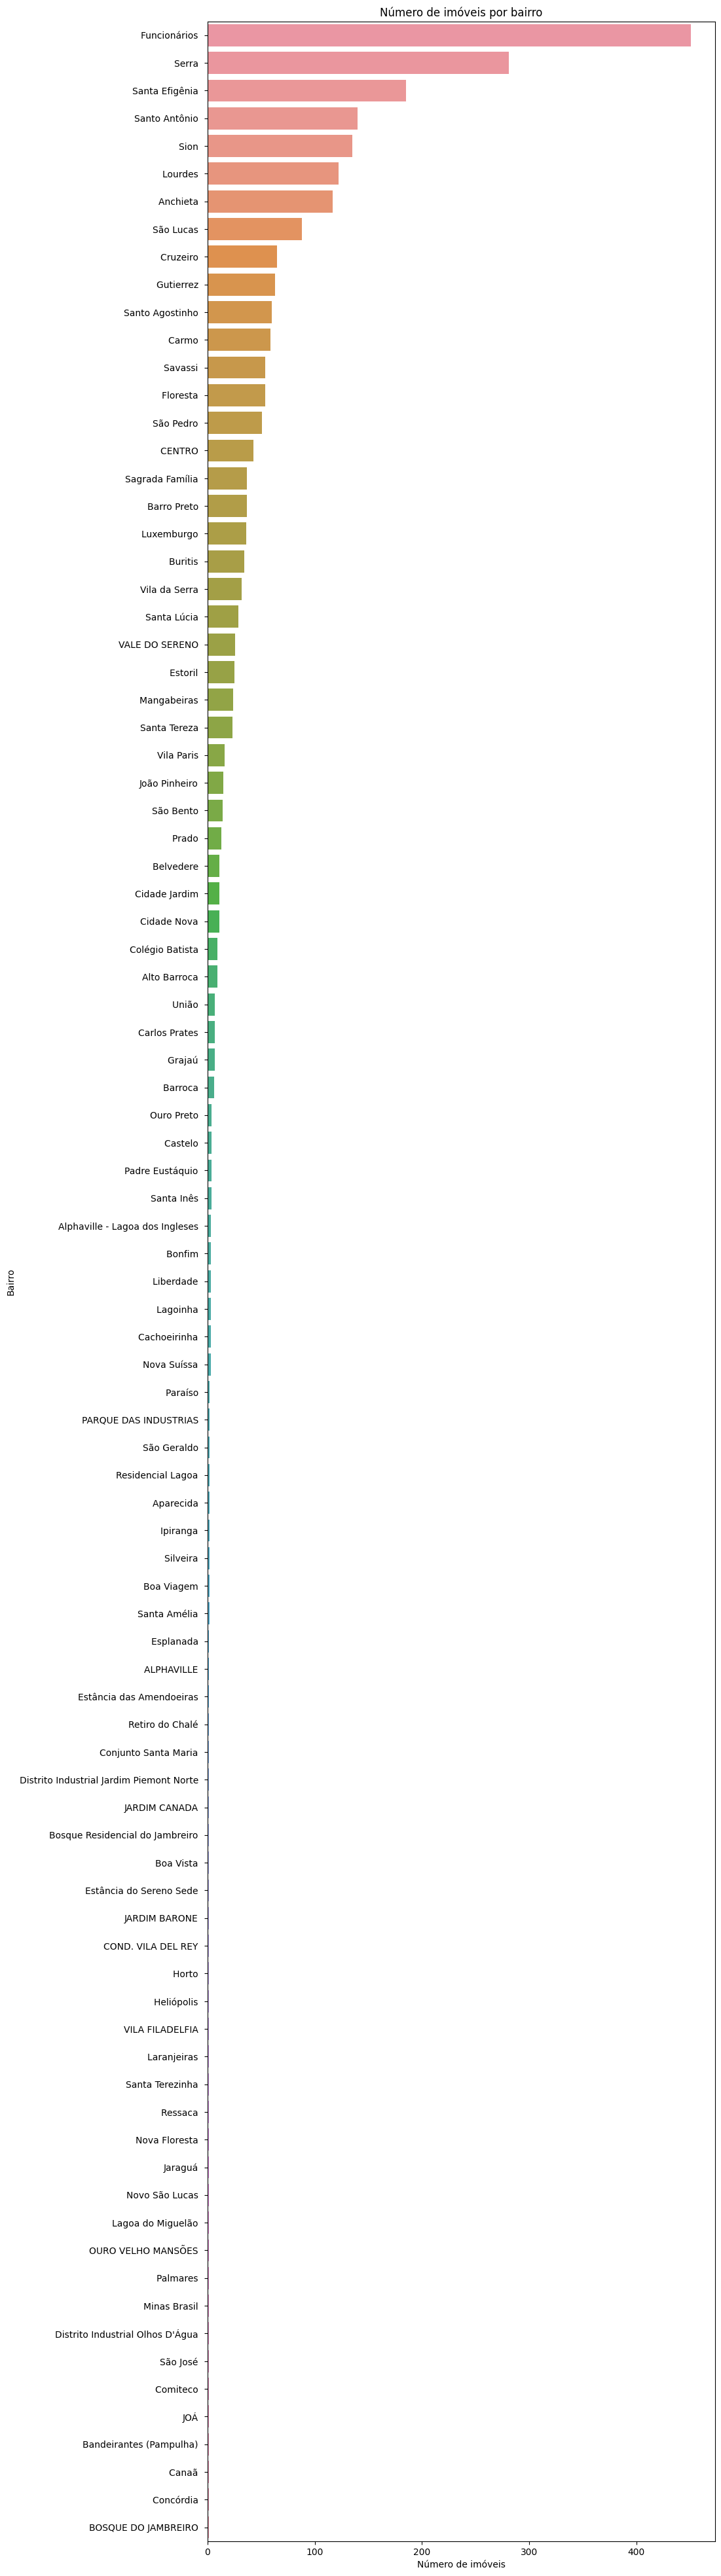

In [24]:
plt.figure(figsize=(10,50))
sns.countplot(y='Bairro', data=df, order=df['Bairro'].value_counts().index)
plt.title('Número de imóveis por bairro')
plt.xlabel('Número de imóveis')
plt.ylabel('Bairro')
plt.show()

## Geocodificação dos Endereços

Agora vamos utilizar o serviço de geocodificação para obter a latitude e longitude de cada imóvel.


In [25]:
# Use Geopy para obter as coordenadas de latitude e longitude dos endereços
geolocator = Nominatim(user_agent='myGeocoder')

# Função para lidar com o GeocoderTimedOut
def do_geocode(address):
    try:
        return geolocator.geocode(address, timeout=15)
    except GeocoderTimedOut:
        return do_geocode(address)

# Cria uma nova coluna 'coords' com as coordenadas de cada imóvel
df['coords'] = df['Endereço'].apply(lambda x: do_geocode(x) if x else None)
df['coords'] = df['coords'].apply(lambda x: (x.latitude, x.longitude) if x else (None, None))

# Agora, 'coords' é uma coluna de tuplas, então vamos dividi-la em duas colunas: 'latitude' e 'longitude'
df[['latitude', 'longitude']] = pd.DataFrame(df['coords'].tolist(), index=df.index)

# Exclui a coluna 'coords' pois ela já não é mais necessária
df = df.drop(['coords'], axis=1)


KeyboardInterrupt: 

## Criação do Mapa

Vamos utilizar a biblioteca Folium para criar um mapa interativo dos imóveis.


In [ ]:
# Lendo os dados do mapa de bairros de Belo Horizonte
url = 'https://geoservicos.pbh.gov.br/geoserver/wfs?service=WFS&version=1.0.0&request=GetFeature&typeName=ide_bhgeo:BAIRRO&srsName=EPSG:31983&outputFormat=application%2Fjson'
gdf = gpd.read_file(url)

# Convertendo para lat-long
gdf = gdf.to_crs(epsg=4326)

# Converta o DataFrame em um GeoDataFrame
gdf_imoveis = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Cria o mapa com os bairros de Belo Horizonte
x_map = gdf.geometry.centroid.x.mean()
y_map = gdf.geometry.centroid.y.mean()
mymap = folium.Map(location=[y_map, x_map], zoom_start=11, tiles='OpenStreetMap')

# Adiciona os polígonos dos bairros ao mapa
folium.GeoJson(gdf).add_to(mymap)

# Adiciona os pontos de cada imóvel ao mapa
for _, imovel in gdf_imoveis.iterrows():
    popup_text = f"Título: {imovel['Título']}<br> Endereço: {imovel['Endereço']}<br> Preço: {imovel['Preço']}"
    folium.Marker(location=[imovel['latitude'], imovel['longitude']],
                  popup=popup_text).add_to(mymap)

mymap.save('mapa.html')
